# __Customer Segmentation with Unsupervised Learning: KMeans clustering__

## Dataset : [Superstore Sales Dataset](https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting)

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


# Data Sanity Check (Initial Exploration)

In [4]:
df.shape

(9800, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [6]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [7]:
df.nunique()

Row ID           9800
Order ID         4922
Order Date       1230
Ship Date        1326
Ship Mode           4
Customer ID       793
Customer Name     793
Segment             3
Country             1
City              529
State              49
Postal Code       626
Region              4
Product ID       1861
Category            3
Sub-Category       17
Product Name     1849
Sales            5757
dtype: int64

In [8]:
df[df.duplicated(keep=False)] # checking duplicate rows

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales


# Data Preprocessing: Date conversion

In [9]:
# "Order Date" and "Ship Date" to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   datetime64[ns]
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [11]:
# Deriveing new features- "Total Sales per Customer" and "Order Frequency"
df['Total Sales per Customer'] = df.groupby('Customer ID')['Sales'].transform('sum')
df['Order Frequency'] = df.groupby('Customer ID')['Order ID'].transform('nunique')

In [12]:
# Deriving "Days to Ship"
df['Days to Ship'] = (df['Ship Date'] - df['Order Date']).dt.days

In [13]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Total Sales per Customer,Order Frequency,Days to Ship
0,1,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,1148.7800,3,3
1,2,CA-2017-152156,2017-11-08,2017-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,1148.7800,3,3
2,3,CA-2017-138688,2017-06-12,2017-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,1119.4830,5,4
3,4,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,2602.5755,6,7
4,5,US-2016-108966,2016-10-11,2016-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2602.5755,6,7


In [14]:
# summarizing data info - data types, null values, and unique values

tab_info = pd.DataFrame({
    'data type': df.dtypes,
    'null values': df.isnull().sum(),
    'unique values': df.nunique(),
})

print('-' * 20 + " Info about Data Types, Unique Values, and Null Values " + '-' * 20)
print("  ")
print(tab_info.to_string())

-------------------- Info about Data Types, Unique Values, and Null Values --------------------
  
                               data type  null values  unique values
Row ID                             int64            0           9800
Order ID                          object            0           4922
Order Date                datetime64[ns]            0           1230
Ship Date                 datetime64[ns]            0           1326
Ship Mode                         object            0              4
Customer ID                       object            0            793
Customer Name                     object            0            793
Segment                           object            0              3
Country                           object            0              1
City                              object            0            529
State                             object            0             49
Postal Code                      float64           11            626
Regi

# Exploratory Data Analysis (EDA)

### Percent Distribution of categorical features

In [15]:
print(f"Percent Distribution of {df['Days to Ship'].value_counts(normalize=True, dropna=False).mul(100).apply('{:.2f}%'.format)}")

Percent Distribution of Days to Ship
4    27.73%
5    21.91%
2    13.21%
6    11.94%
3     9.98%
7     6.28%
0     5.24%
1     3.70%
Name: proportion, dtype: object


In [16]:
print(f"Percent Distribution of {df['Ship Mode'].value_counts(normalize=True, dropna=False).mul(100).apply('{:.2f}%'.format)}")

Percent Distribution of Ship Mode
Standard Class    59.79%
Second Class      19.41%
First Class       15.32%
Same Day           5.49%
Name: proportion, dtype: object


###  Visualizing categorical feature distributions

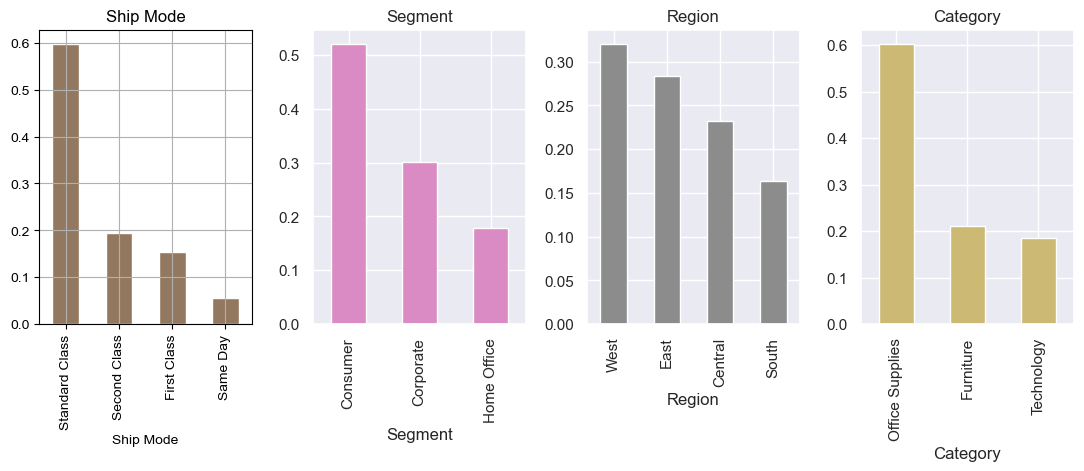

In [17]:
plt.figure(1)
plt.subplot(241)
sns.set_theme(style="darkgrid")
df['Ship Mode'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(11,8), title='Ship Mode', color='C5');

plt.subplot(242)
sns.set_theme(style="darkgrid")
df['Segment'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(11, 8), title='Segment', color='C6');

plt.subplot(243)
sns.set_theme(style="darkgrid")
df['Region'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(11,8), title='Region', color='C7');

plt.subplot(244)
sns.set_theme(style="darkgrid")
df['Category'].value_counts(normalize=True, dropna=False).plot.bar(figsize=(11,8), title='Category', color='C8');
plt.tight_layout()

### Observations from EDA:
>    - Around 60% of the shipment happens in 'Standard Class' mode.
>    - 'Consumer' segment makes up for around 50% of dataset
>    - 60% of the items are 'Office Supplies'
>    - Majority of the items in dataset are from the 'West' region

# Feature Selection and Engineering

In [18]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Total Sales per Customer', 'Order Frequency',
       'Days to Ship'],
      dtype='object')

In [19]:
# model_df = df.copy(deep=True)

# Dropping Unnecessary Features
df.drop(['Sales', 'Row ID', 'Order ID', 'Customer Name', 'Country', 'City', 'State', 'Postal Code', 'Product ID', 'Sub-Category', 'Product Name', 'Order Date', 'Ship Date'], axis=1, inplace=True)

In [20]:
df.columns

Index(['Ship Mode', 'Customer ID', 'Segment', 'Region', 'Category',
       'Total Sales per Customer', 'Order Frequency', 'Days to Ship'],
      dtype='object')

### Dropped Useless Features

> - `Row ID`: Unique identifier for each row, not useful for segmentation.
> - `Order ID`: Specific to orders, not directly relevant to customer segmentation.
> - `Order Date and Ship Date`: Dates themselves might not be directly useful, but derived features can be.
> - `Customer Name`: Text data, not useful for segmentation.
> - `Product ID, Product Name`: Specific to products, not useful for customer-level segmentation.
> - `Country, City, State, Postal Code`: Detailed location information might be too granular. Region might be sufficient.
> - `Category, Sub-Category`: Product categories might be more relevant than specific products.
> - `Customer ID` should be retained for reference but not used in the clustering algorithm.

In [21]:
df.shape

(9800, 8)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ship Mode                 9800 non-null   object 
 1   Customer ID               9800 non-null   object 
 2   Segment                   9800 non-null   object 
 3   Region                    9800 non-null   object 
 4   Category                  9800 non-null   object 
 5   Total Sales per Customer  9800 non-null   float64
 6   Order Frequency           9800 non-null   int64  
 7   Days to Ship              9800 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 612.6+ KB


# Outlier Detection and Handling

In [23]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

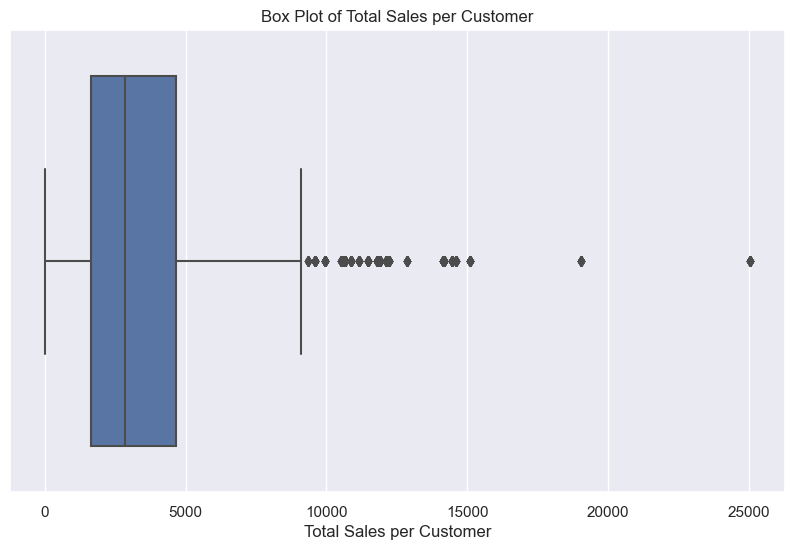

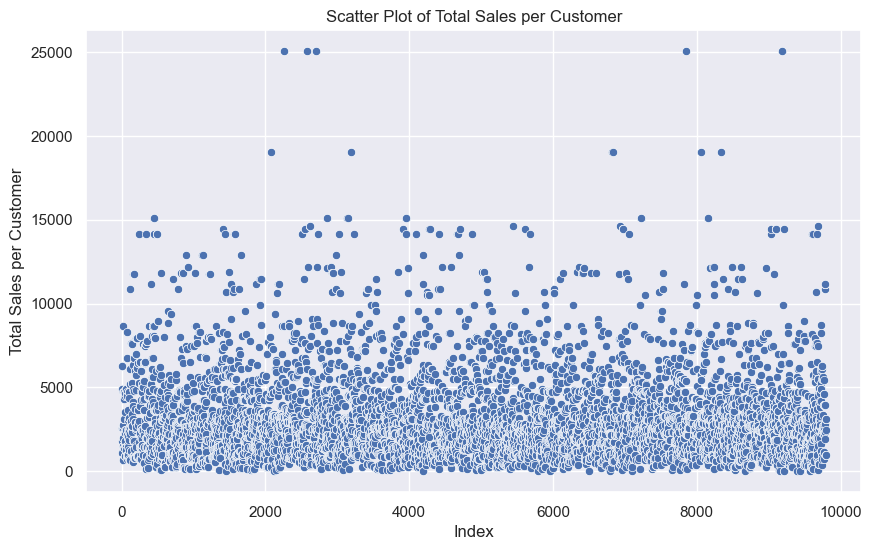

In [24]:
# outliers in 'Total Sales per Customer'

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Total Sales per Customer'])
plt.title('Box Plot of Total Sales per Customer')
plt.xlabel('Total Sales per Customer')
plt.show()

# Scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(df)), y=df['Total Sales per Customer'])
plt.title('Scatter Plot of Total Sales per Customer')
plt.xlabel('Index')
plt.ylabel('Total Sales per Customer')
plt.show()

In [25]:
# Interquartile range (IQR)
IQR= df['Total Sales per Customer'].quantile(0.75) - df['Total Sales per Customer'].quantile(0.25)
lower_bridge= df['Total Sales per Customer'].quantile(0.25)-(IQR*1.5)
upper_bridge= df['Total Sales per Customer'].quantile(0.75)+(IQR*1.5)
df.loc[df['Total Sales per Customer']>upper_bridge,'Total Sales per Customer'] = upper_bridge

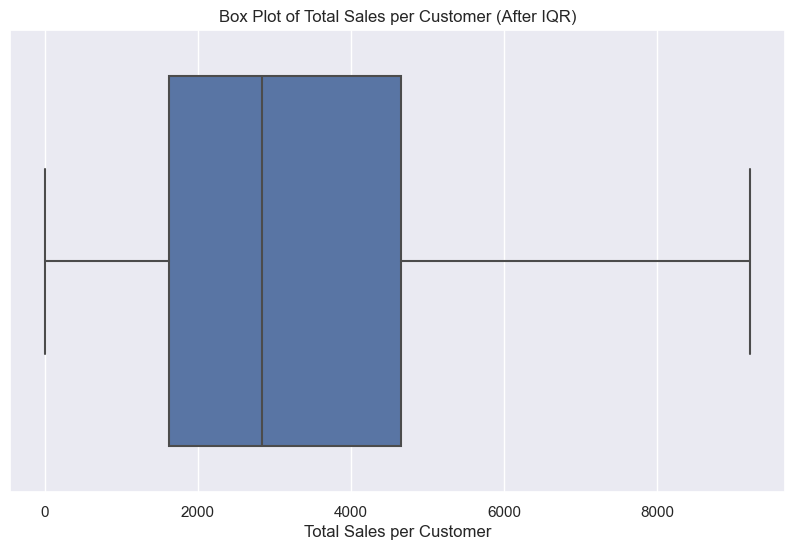

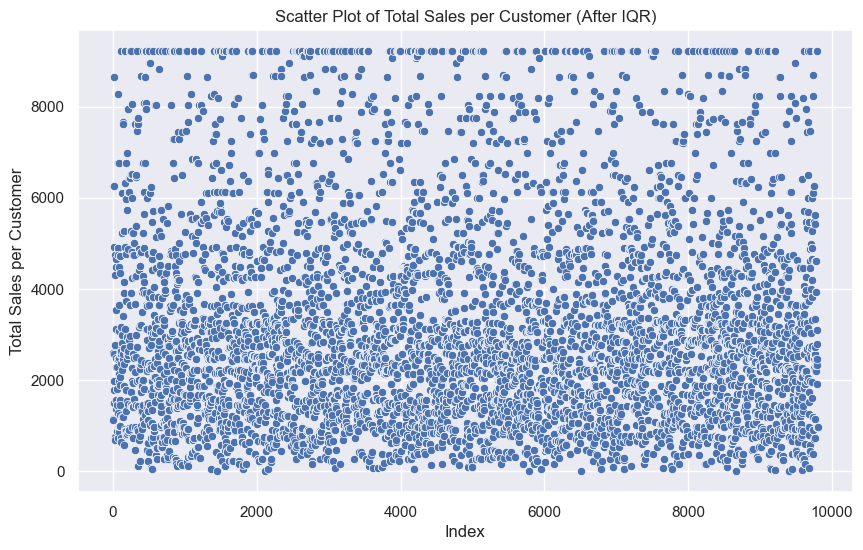

In [26]:
# Box plot after interquartile range (IQR) transformation
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Total Sales per Customer'])
plt.title('Box Plot of Total Sales per Customer (After IQR)')
plt.xlabel('Total Sales per Customer')
plt.show()

# Scatter plot after interquartile range (IQR) transformation
plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(df)), y=df['Total Sales per Customer'])
plt.title('Scatter Plot of Total Sales per Customer (After IQR)')
plt.xlabel('Index')
plt.ylabel('Total Sales per Customer')
plt.show()

# OneHot Encoding and Standard Scaling

In [27]:
# Identified categorical and numerical features
categorical_features = ['Ship Mode', 'Segment', 'Region', 'Category']
numerical_features = ['Total Sales per Customer', 'Order Frequency', 'Days to Ship']

In [28]:
# ColumnTransformer with OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Applying transformations
df_preprocessed = preprocessor.fit_transform(df)

In [29]:
# Convert the transformed data back to a DataFrame for easier manipulation
num_features = numerical_features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = num_features + list(cat_features)

# Convert the array back to a DataFrame
df_transformed = pd.DataFrame(df_preprocessed, columns=all_features)

In [30]:
df_transformed.shape

(9800, 17)

In [31]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Total Sales per Customer  9800 non-null   float64
 1   Order Frequency           9800 non-null   float64
 2   Days to Ship              9800 non-null   float64
 3   Ship Mode_First Class     9800 non-null   float64
 4   Ship Mode_Same Day        9800 non-null   float64
 5   Ship Mode_Second Class    9800 non-null   float64
 6   Ship Mode_Standard Class  9800 non-null   float64
 7   Segment_Consumer          9800 non-null   float64
 8   Segment_Corporate         9800 non-null   float64
 9   Segment_Home Office       9800 non-null   float64
 10  Region_Central            9800 non-null   float64
 11  Region_East               9800 non-null   float64
 12  Region_South              9800 non-null   float64
 13  Region_West               9800 non-null   float64
 14  Category

# Model Building (KMeans Clustering)
### WCSS (Within Cluster Sum of Squares) for Elbow Method

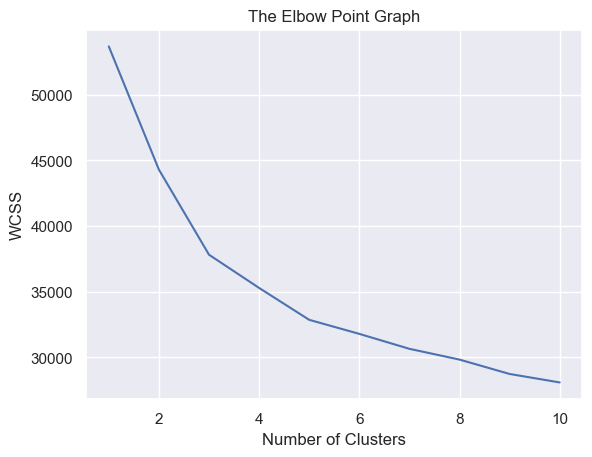

In [32]:
# Elbow Method for Optimal K

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_transformed)

    wcss.append(kmeans.inertia_)

# Plot the elbow graph
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
# Model: KMeans Clustering

km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df_transformed)
y_predicted

array([2, 2, 1, ..., 1, 1, 1])

In [34]:
# Adding cluster labels to the original dataframe

df['cluster']=y_predicted
df.head()

,Ship Mode,Customer ID,Segment,Region,Category,Total Sales per Customer,Order Frequency,Days to Ship,cluster
0,Second Class,CG-12520,Consumer,South,Furniture,1148.7800,3,3,2
1,Second Class,CG-12520,Consumer,South,Furniture,1148.7800,3,3,2
2,Second Class,DV-13045,Corporate,West,Office Supplies,1119.4830,5,4,1
3,Standard Class,SO-20335,Consumer,South,Furniture,2602.5755,6,7,1
4,Standard Class,SO-20335,Consumer,South,Office Supplies,2602.5755,6,7,1


# Visualizing clusters

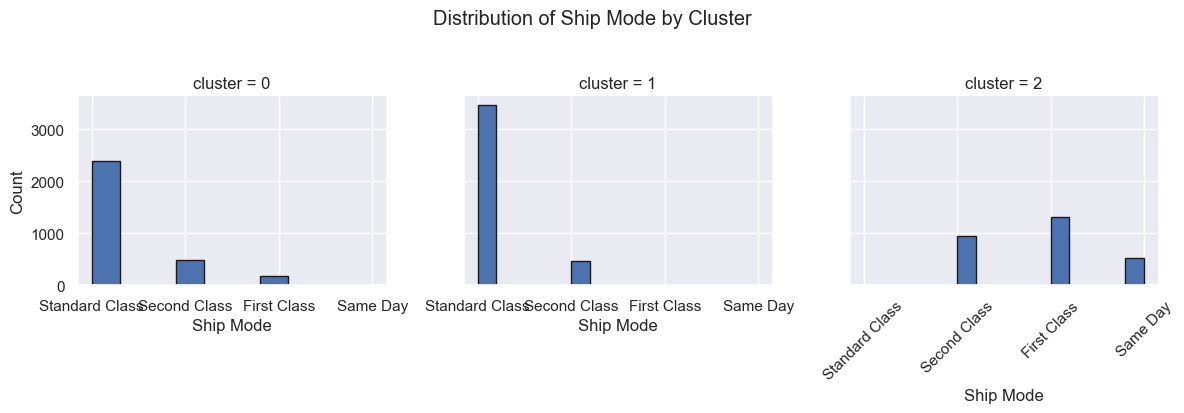

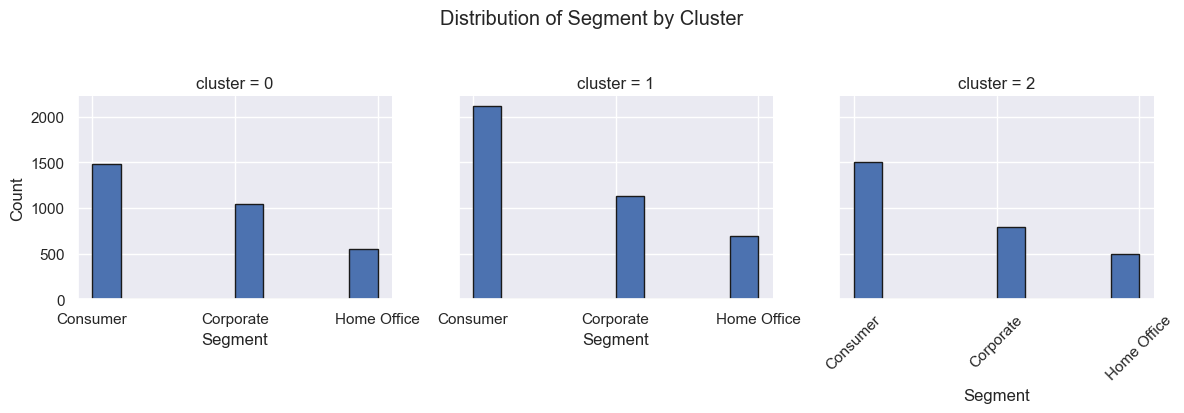

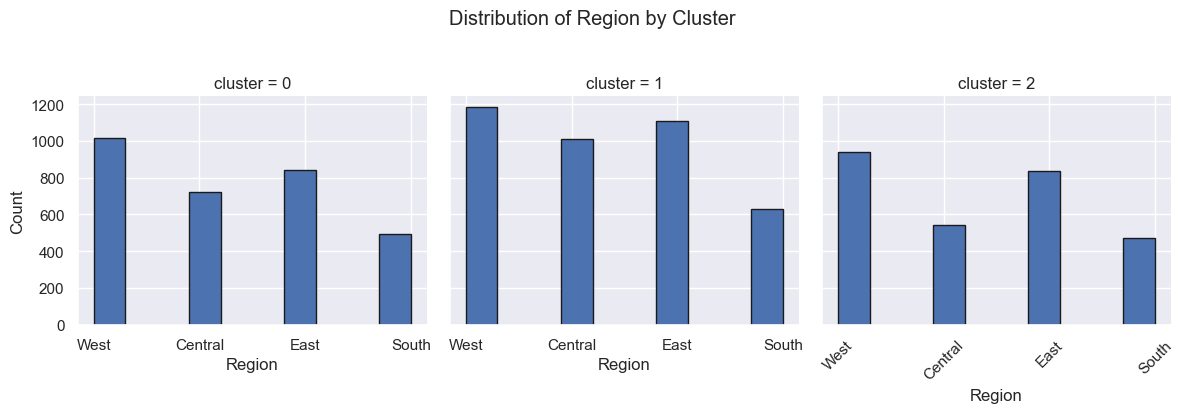

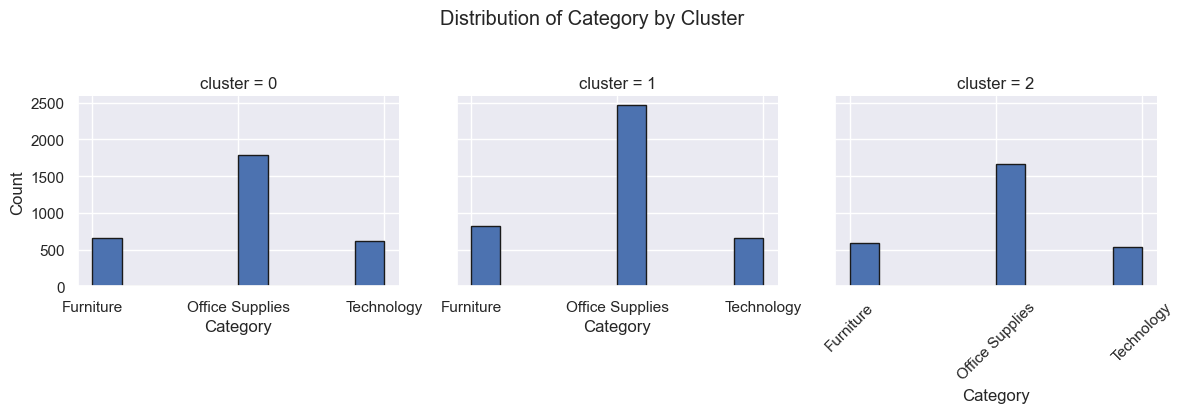

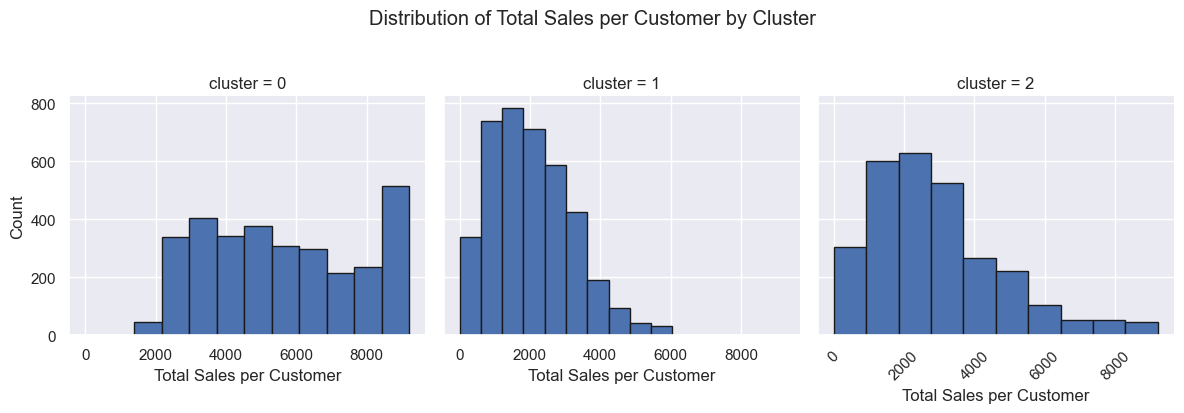

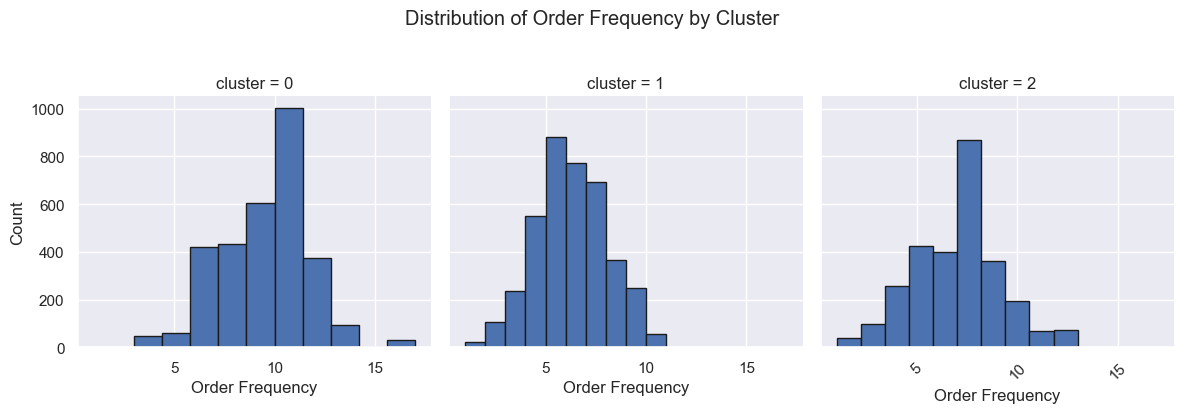

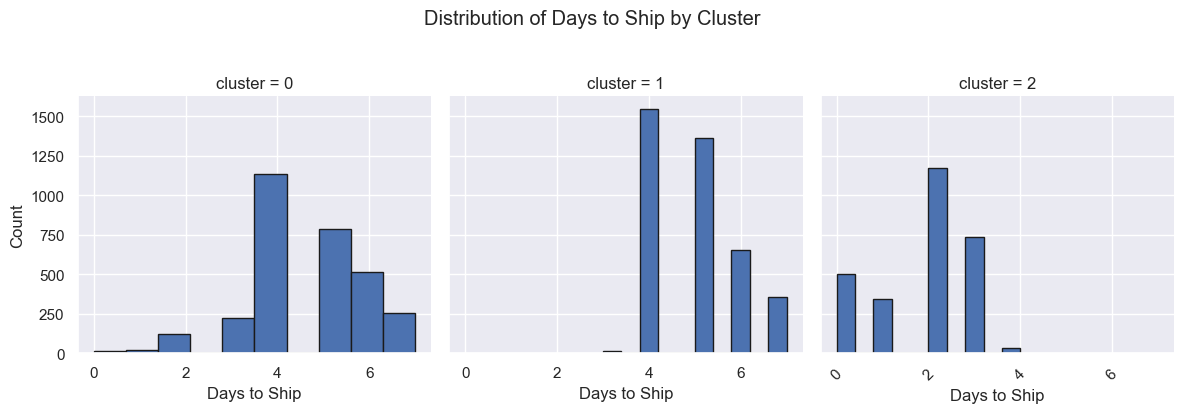

In [35]:
# List of features to visualize
features = ['Ship Mode', 'Segment', 'Region', 'Category', 'Total Sales per Customer', 'Order Frequency', 'Days to Ship']

# Loop each feature for bar plot
for feature in features:
    grid = sns.FacetGrid(df, col='cluster', height=4, aspect=1)
    grid.map(plt.hist, feature, bins=10, color='b', edgecolor='k')
    
    # title
    grid.fig.suptitle(f'Distribution of {feature} by Cluster', y=1.03)
    
    # plot
    grid.set_axis_labels(feature, 'Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    grid.fig.canvas.draw()

# Customer Segmentation Insights:

## The graph reveals variations in customer behavior across clusters.
    
> - Ship Mode: Cluster 0 favors "Standard Class" shipping, while others show a more balanced preference
> - Demographics (Segment, Region): Cluster 0 might have more "Consumer" customers from a specific region (potentially "South" or "West")
> - Product Category: Cluster distribution varies (e.g., Cluster 0 might have a dominant category).
> - Purchase Behavior (Order Frequency, Days to Ship): Cluster 0 indicates less frequent orders with potentially longer shipping times.
> - Total Sales: Cluster 0 suggests a higher proportion of lower-spending customers.
>     - Purchase Behavior: Cluster 0 likely has a higher proportion of customers with lower total sales and order frequency, and potentially longer shipping times. Cluster 1 and 2 could exhibit a wider range in these aspects.

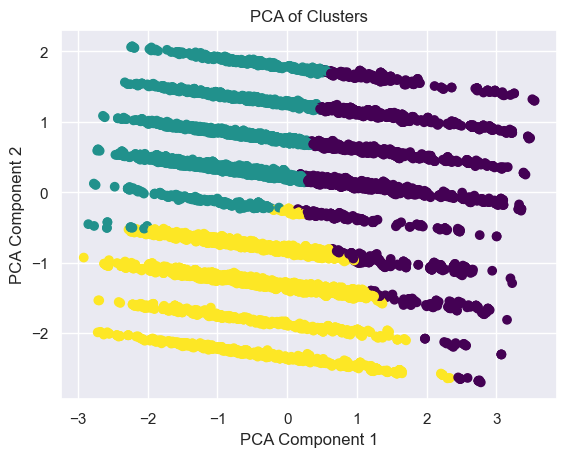

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(df_transformed)
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=y_predicted, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters')
plt.show()
